# Comparison of ODE solvers for Keplerian mechanics 

In [1]:
using Plots
using Statistics
using BenchmarkTools

using StaticArrays
using LinearAlgebra
using DifferentialEquations

include("kepler.jl") # μ, M2f, f2M, rv_to_coe, coe_to_rv, kepler_solver

function first_order_newton_ode(du, u, p, t)
    factor = - μ / (u[1]^2+u[2]^2+u[3]^2)^(3/2)
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    du[4] = u[1] * factor
    du[5] = u[2] * factor
    du[6] = u[3] * factor
end

function second_order_newton_ode(ddu, du, u, p, t)
    factor = - μ / norm(u)^3
    ddu[1] = u[1] * factor
    ddu[2] = u[2] * factor
    ddu[3] = u[3] * factor
end

pos(rv::AbstractVector{<:Real}) = rv[1:3]
pos(u::ArrayPartition{<:Real}) = u.x[2]
pos(sol::ODESolution) = pos(sol[end])

vel(rv::AbstractVector{<:Real}) = rv[4:6]
vel(u::ArrayPartition{<:Real}) = u.x[1]
vel(sol::ODESolution) = vel(sol[end])

energy(rv::AbstractVector{<:Real}) = rv[4:6]'rv[4:6]/2 - μ/norm(rv[1:3])
energy(u::ArrayPartition{<:Real}) = u.x[1]'u.x[1]/2 - μ/norm(u.x[2])

import Base.+
+(range::StepRange, n::Int) = StepRange(range.start + n, range.step, range.stop + n)
+(n::Int, range::StepRange) = StepRange(range.start + n, range.step, range.stop + n);

## Double-precision benchmarks

Functions to benchmark the algorithms and plot the results.

In [2]:
function benchmark_tol(prob, alg, tols; seconds=.1)
    benches = []
    for tol in tols
        sol = solve(prob, alg; abstol=tol, reltol=tol, save_on=false)
        bench = @benchmark solve($prob, $alg; abstol=$tol, reltol=$tol, save_on=false) seconds=seconds
        push!(benches, (sol=sol, bench=bench, t=1e-9*mean(bench.times)))
    end
    return benches
end

function benchmark_dt(prob, alg, dts; seconds=.1)
    benches = []
    for dt in dts
        sol = solve(prob, alg; dt=dt, save_on=false)
        bench = @benchmark solve($prob, $alg; dt=$dt, save_on=false) seconds=seconds
        push!(benches, (sol=sol, bench=bench, t=1e-9*mean(bench.times)))
    end
    return benches
end

function plot_benchmark(bench, true_pos)
    plot(
        [b[:t] for b in bench],
        [norm(pos(b[:sol]) - true_pos) for b in bench],
        xlabel="Time", ylabel="Error", label=bench[1][:sol].alg,
        scale=:log10, marker=:circle)
end

function plot_benchmark!(bench, true_pos)
    plot!(
        [b[:t] for b in bench],
        [norm(pos(b[:sol]) - true_pos) for b in bench],
        xlabel="Time", ylabel="Error", label=bench[1][:sol].alg,
        scale=:log10, marker=:circle)
end;

Define the initial conditions and the first and second order problems.

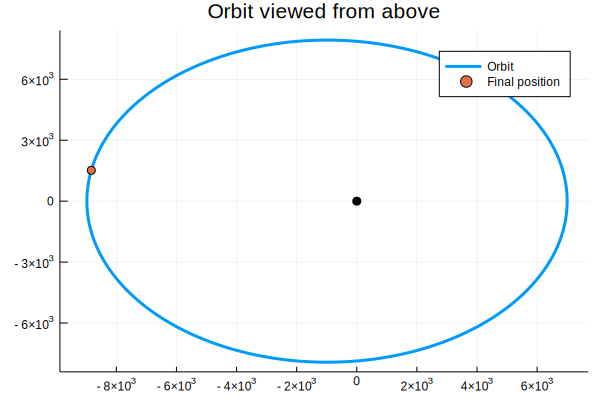

In [3]:
# units: position [km], velocity [km/2]
r0 = [7000., 0., 0.]; v0 = [0., 8., 0.];
rv0 = vcat(r0, v0);
tspan = (0., 3*86400.)
tstops = 2*86400 + (0:600:86400)

sol_kepler = kepler_solver(r0, v0)

prob_first = ODEProblem(first_order_newton_ode, rv0, tspan)
prob_second = SecondOrderODEProblem(second_order_newton_ode, v0, r0, tspan)

sol = solve(prob_first, Vern9(); abstol=1e-12, reltol=1e-12);
plot(sol, vars=(1,2), label="Orbit", title="Orbit viewed from above")
scatter!([sol[1,end]], [sol[2,end]], label="Final position")
scatter!([[0]], [[0]], label="", color=:black)

Run all the benchmarks.

In [4]:
tols_5_13 = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
tols_5_14 = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
dts = [1000, 500, 100, 50, 10, 5, 1]

benches_first_low = []
for alg in [RK4(), BS5(), DP5(), Tsit5()]
    print(alg, " "); flush(stdout)
    push!(benches_first_low,
        alg => benchmark_tol(prob_first, alg, tols_5_13))
end

println()
benches_first_high = []
for alg in [DP8(), TsitPap8(), Vern7(), Vern8(), Vern9(), Feagin10(), Feagin12(), Feagin14()]
    print(alg, " "); flush(stdout)
    push!(benches_first_high,
        alg => benchmark_tol(prob_first, alg, tols_5_14))
end

println()
benches_second_nystrom = []
for alg in [DPRKN6(), DPRKN8(), DPRKN12()]
    print(alg, " "); flush(stdout)
    push!(benches_second_nystrom,
        alg => benchmark_tol(prob_second, alg, tols_5_14))
end

println()
benches_second_symplectic = []
for alg in [McAte5(), KahanLi6(), KahanLi8(), SofSpa10()]
    print(alg, " "); flush(stdout)
    push!(benches_second_symplectic,
        alg => benchmark_dt(prob_second, alg, dts))
end

benches_all = [
    benches_first_low...,
    benches_first_high...,
    benches_second_nystrom...,
    benches_second_symplectic...];

RK4() BS5(true) DP5() Tsit5() 
DP8() TsitPap8() Vern7(true) Vern8(true) Vern9(true) Feagin10() Feagin12() Feagin14() 
DPRKN6() DPRKN8() DPRKN12() 
McAte5() KahanLi6() KahanLi8() SofSpa10() 

In [5]:
ref_pos = real_pos = sol_kepler(tspan[2])[1:3]

3-element Array{BigFloat,1}:
 -8832.959418056082485483806369696069781722380044090297709715278888377886488597771
  1516.637769997941283708210356653529835902098220150785342775226034153681164539952
     0.0                                                                          

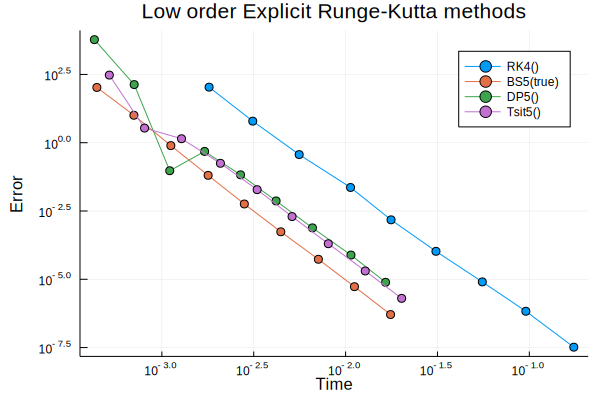

In [6]:
plot(title="Low order Explicit Runge-Kutta methods")
for (alg, bench) in benches_first_low
    plot_benchmark!(bench, ref_pos)
end
p_low = plot!()

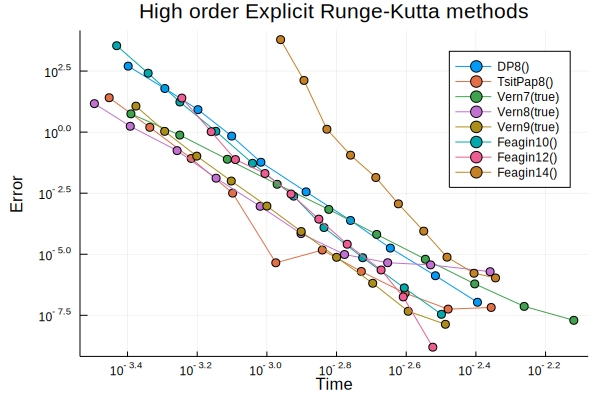

In [7]:
plot(title="High order Explicit Runge-Kutta methods")
for (alg, bench) in benches_first_high
    plot_benchmark!(bench, ref_pos)
end
p_high = plot!()

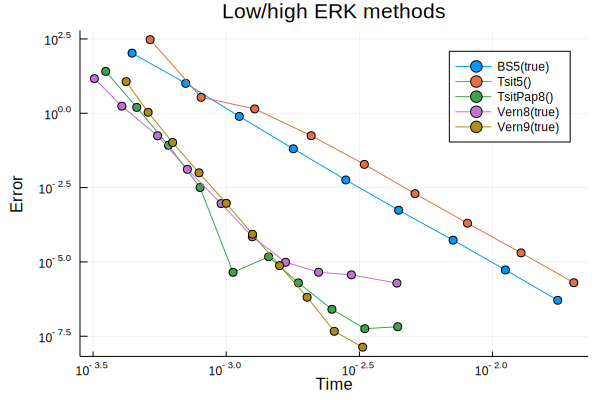

In [8]:
plot(title="Low/high ERK methods")
for alg in [BS5(), Tsit5(), TsitPap8(), Vern8(), Vern9()]
    plot_benchmark!(Dict(benches_all)[alg], real_pos)
end
p_rk = plot!()

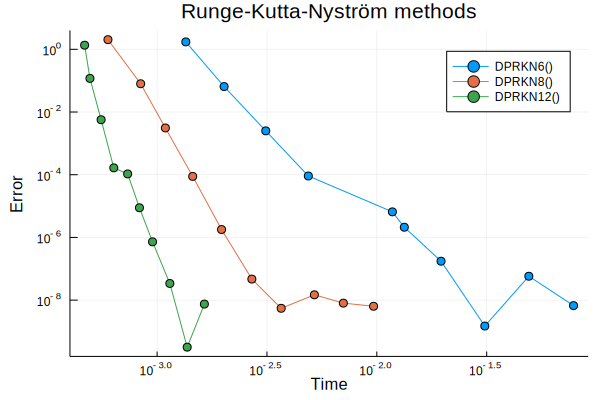

In [9]:
plot(title="Runge-Kutta-Nyström methods")
for (alg, bench) in benches_second_nystrom
    plot_benchmark!(bench, real_pos)
end
p_nystrom = plot!()

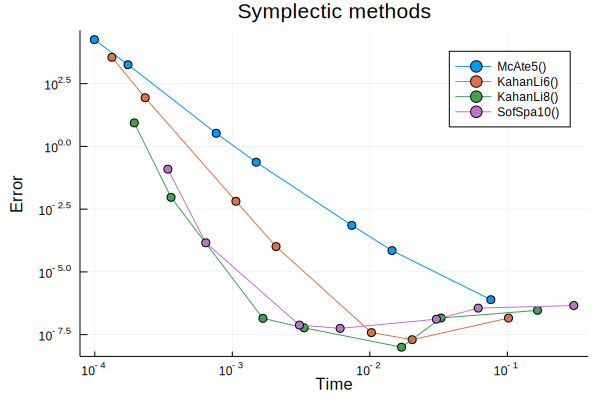

In [10]:
plot(title="Symplectic methods")
for (alg, bench) in benches_second_symplectic
    plot_benchmark!(bench, real_pos)
end
p_symplectic = plot!()

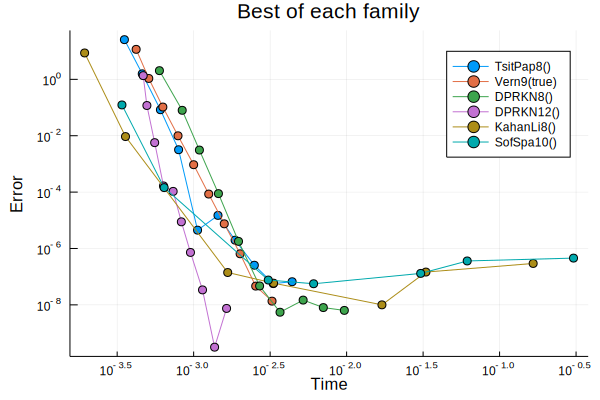

In [11]:
plot(title="Best of each family")
for alg in [TsitPap8(), Vern9(), DPRKN8(), DPRKN12(), KahanLi8(), SofSpa10()]
    plot_benchmark!(Dict(benches_all)[alg], real_pos)
end
p_best = plot!()

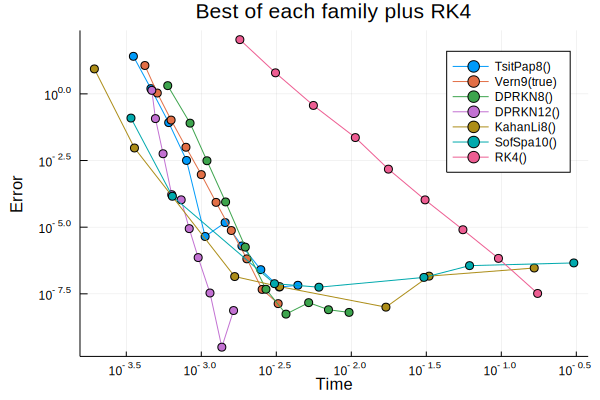

In [12]:
plot(title="Best of each family plus RK4")
for alg in [TsitPap8(), Vern9(), DPRKN8(), DPRKN12(), KahanLi8(), SofSpa10(), RK4()]
    plot_benchmark!(Dict(benches_all)[alg], real_pos)
end
p_best_rk4 = plot!()

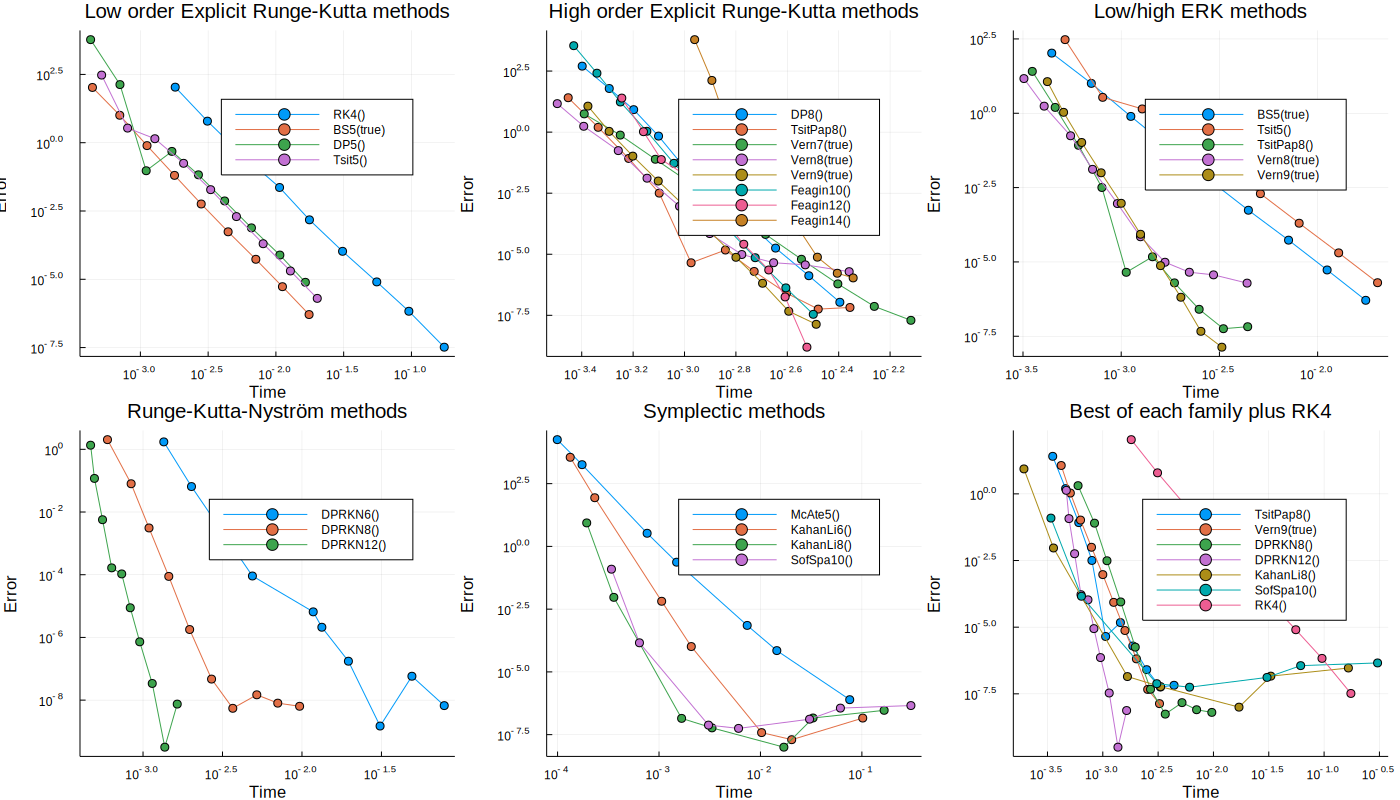

In [13]:
plot(p_low, p_high, p_rk, p_nystrom, p_symplectic, p_best_rk4, size=(1400, 800))